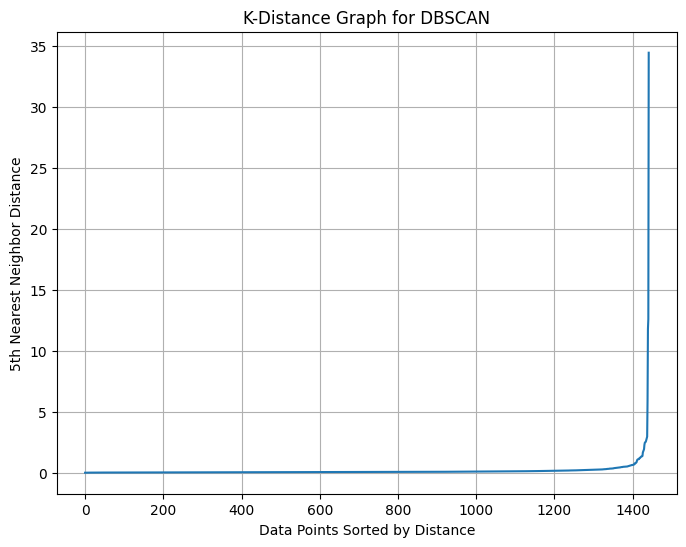

DBSCAN Cluster Counts:
 0    1388
-1      43
 2       6
 1       5
Name: count, dtype: int64
Silhouette Score for DBSCAN: 0.527


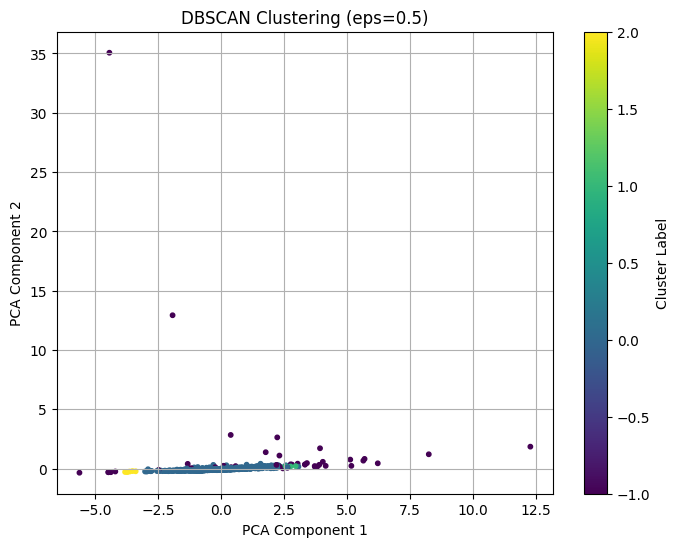

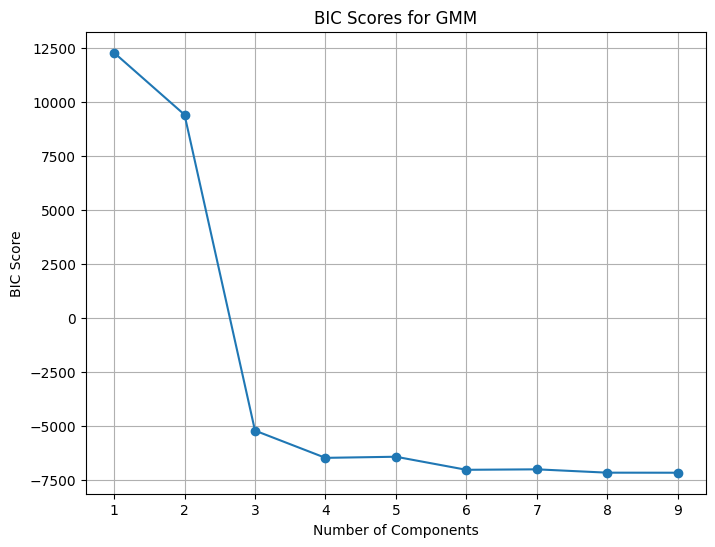

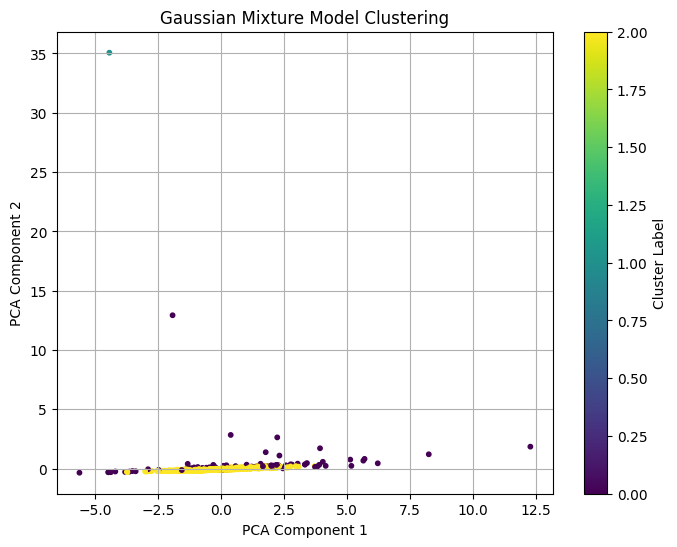


Cluster Analysis (Mean and Std of Metrics with Labels):
            Inventory turnover rate (Times)               \
                                       mean          std   
GMM_Cluster                                                
0                                465.940654  2614.792520   
1                              75684.530000          NaN   
2                                  4.378354     3.829626   

            Total asset turnover rate (Times)                 ROA            \
                                         mean       std      mean       std   
GMM_Cluster                                                                   
0                                    1.284570  1.463668  0.043482  0.209588   
1                                    0.370000       NaN -0.050000       NaN   
2                                    0.599982  0.325819  0.055701  0.082079   

               Cluster Label  
                              
GMM_Cluster                   
0            U

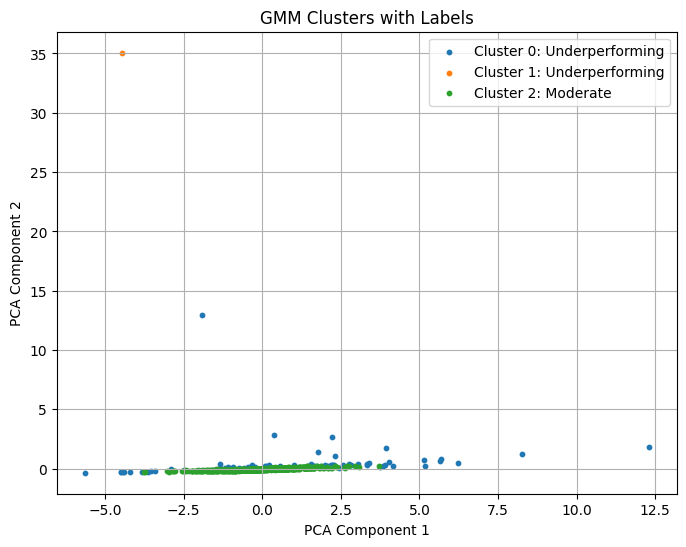

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np


file_path = 'train.csv'
data = pd.read_csv(file_path)


features = ['Inventory turnover rate (Times)', 'Total asset turnover rate (Times)', 'ROA']
efficiency_data = data[features]


efficiency_data = efficiency_data.fillna(efficiency_data.median())


scaler = StandardScaler()
efficiency_data_normalized = scaler.fit_transform(efficiency_data)


neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(efficiency_data_normalized)
distances, _ = nbrs.kneighbors(efficiency_data_normalized)
sorted_distances = np.sort(distances[:, 4])

plt.figure(figsize=(8, 6))
plt.plot(sorted_distances)
plt.title('K-Distance Graph for DBSCAN')
plt.xlabel('Data Points Sorted by Distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.grid()
plt.show()


eps = 0.5
dbscan = DBSCAN(eps=eps, min_samples=5)
dbscan_labels = dbscan.fit_predict(efficiency_data_normalized)


dbscan_cluster_counts = pd.Series(dbscan_labels).value_counts()
print("DBSCAN Cluster Counts:")
print(dbscan_cluster_counts)


if len(set(dbscan_labels)) > 1:
    silhouette_avg = silhouette_score(efficiency_data_normalized[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"Silhouette Score for DBSCAN: {silhouette_avg:.3f}")
else:
    print("Silhouette Score cannot be calculated for a single cluster.")


pca = PCA(n_components=2)
reduced_data = pca.fit_transform(efficiency_data_normalized)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title(f'DBSCAN Clustering (eps={eps})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.grid()
plt.show()


bic_scores = []
n_components_range = range(1, 10)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(efficiency_data_normalized)
    bic_scores.append(gmm.bic(efficiency_data_normalized))


plt.figure(figsize=(8, 6))
plt.plot(n_components_range, bic_scores, marker='o')
plt.title('BIC Scores for GMM')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.grid()
plt.show()


optimal_components = 3
gmm = GaussianMixture(n_components=optimal_components, random_state=42)
gmm_labels = gmm.fit_predict(efficiency_data_normalized)


plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=gmm_labels, cmap='viridis', s=10)
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.grid()
plt.show()


efficiency_data['GMM_Cluster'] = gmm_labels
cluster_analysis = efficiency_data.groupby('GMM_Cluster').agg(['mean', 'std'])


thresholds = {
    'ROA': 0.05,
    'Inventory turnover rate (Times)': 10,
    'Total asset turnover rate (Times)': 0.8,
}

def label_clusters(row):
    if row['ROA']['mean'] >= thresholds['ROA'] and row['Total asset turnover rate (Times)']['mean'] >= thresholds['Total asset turnover rate (Times)']:
        return 'Efficient'
    elif row['ROA']['mean'] < thresholds['ROA']:
        return 'Underperforming'
    else:
        return 'Moderate'

cluster_analysis['Cluster Label'] = cluster_analysis.apply(label_clusters, axis=1)
print("\nCluster Analysis (Mean and Std of Metrics with Labels):")
print(cluster_analysis)


plt.figure(figsize=(8, 6))
for cluster, label in enumerate(cluster_analysis['Cluster Label']):
    cluster_points = reduced_data[gmm_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}: {label}", s=10)

plt.title('GMM Clusters with Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()
